In [37]:
# Import all the necessarypackages
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn


# This is the structure

Mads
- Load data
- Specify the channel locations
- Common average
- Plot the data 
- Remove bad channels
- Filter the data
- ICA

Andreas
- Load data
- Specify the channel locations
- Common average
- Plot the data 
- Remove bad channels
- Filter the data
- ICA

# 1. Load data - Mads
Alright here is a small explanation for what we are doing: we are defining the EOG channels, which are 'HEOG' and 'VEOG". These are the channels accounting for eye blinks. Then there is the miscellaneous channel, which is the diode thing. 

In [38]:
# Load the data from Mads
path = "/work/raw/own_experiments/Group12_own.vhdr"
raw1 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41']) # Diode 

raw1.load_data()

Extracting parameters from /work/raw/own_experiments/Group12_own.vhdr...
Setting channel info structure...
Reading 0 ... 523239  =      0.000 ...   523.239 secs...


/tmp/ipykernel_7998/2564589986.py:3: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw1 = mne.io.read_raw_brainvision(path, preload=True, eog = ('HEOG','VEOG'), misc = ['41']) # Diode


<RawBrainVision | Group12_own.eeg, 33 x 523240 (523.2 s), ~131.8 MB, data loaded>

# 2. Specify the channel locations - Mads

In [39]:
# Specify the channel locations
montage = mne.channels.make_standard_montage('standard_1020') 
raw1.set_montage(montage, verbose=False)

<RawBrainVision | Group12_own.eeg, 33 x 523240 (523.2 s), ~131.8 MB, data loaded>

# 3. Common Average Reference - Mads

In [40]:
# Redefine the reference to a common average
raw1.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group12_own.eeg, 33 x 523240 (523.2 s), ~131.8 MB, data loaded>

# 4. Plot the data - Mads

Lets take a look at the data!

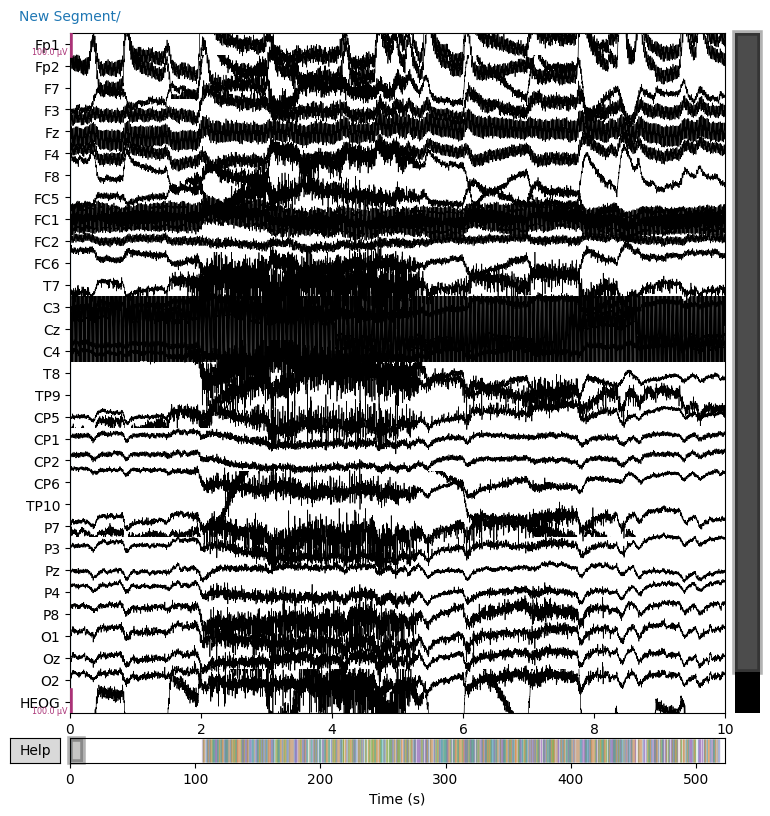

In [41]:
# Plot the data
raw1.plot(n_channels=31, scalings=50e-6);

c3, c4 and cz looks messy. lets plot them, so we can see where they are:

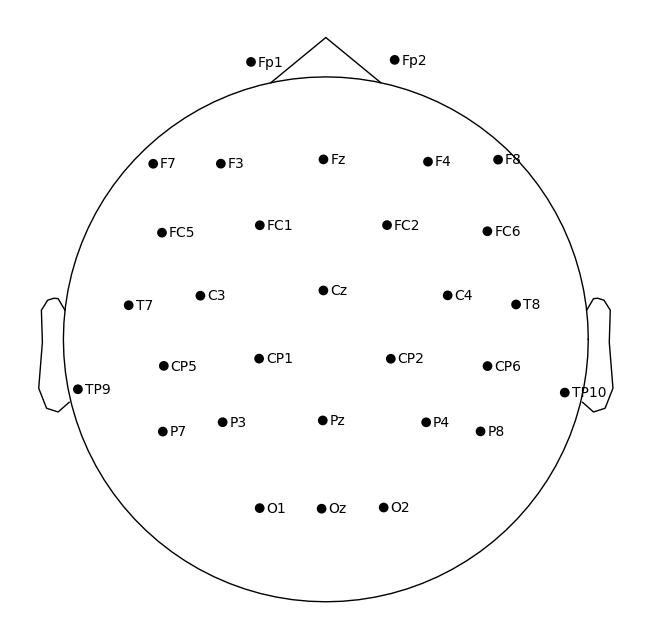

In [42]:
mne.viz.plot_sensors(raw1.info, kind='topomap', ch_type='eeg', show_names=True, title='EEG Sensor Locations');

# 5. Remove bad channels - Mads

Alright c3 and c4 actually does not look that bad, it mainly seems to be cz, that is disrupting the other channels. So,lets remove that. Furthermore we will also remove the diode (41) and FC1 and Fz, as they also don't seem that good

In [43]:
raw1.info["bads"] = ["Cz", "FC1", "41", "Fz"]

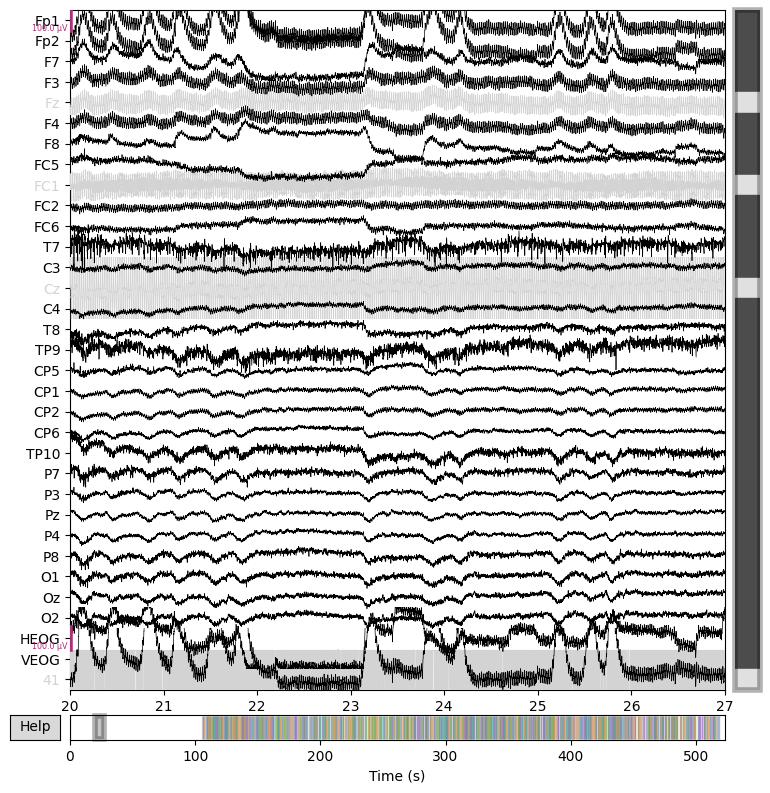

TypeError: Figure.pick() got an unexpected keyword argument 'exclude'

In [44]:
# Plot again after removing bad channels
raw1.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20).pick(exclude="bads");

Ah! looks much better after removing bad channels!

# 6. Filter the data

In [45]:
# Filter the data
raw1.filter(l_freq = 0.1, h_freq = 30) # 0.1 -30 is the convention, thats why we have specified these filters

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


<RawBrainVision | Group12_own.eeg, 33 x 523240 (523.2 s), ~131.8 MB, data loaded>

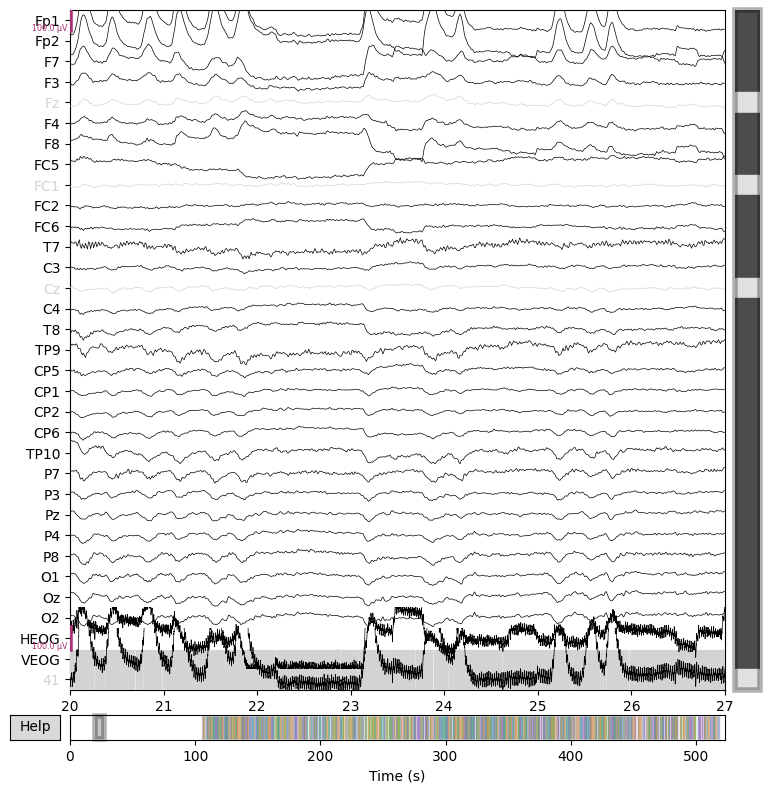

In [46]:
# Plot again to check how it looks after filtering
raw1.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20);

# 7. ICA

In [47]:
# new
raw1.pick_types(meg=False, eeg=True, stim=True, exclude=[])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawBrainVision | Group12_own.eeg, 30 x 523240 (523.2 s), ~119.8 MB, data loaded>

# Filtering to remove slow drifts
Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. A high-pass filter with 1 Hz cutoff frequency is recommended. However, because filtering is a linear operation, the ICA solution found from the filtered signal can be applied to the unfiltered signal (see [2] for more information), so we’ll keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.

In [48]:
ica = mne.preprocessing.ICA(n_components=0.95, max_iter=800, random_state=7)

ica.fit(raw1)

Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 5.8s.


<ICA | raw data decomposition, method: fastica (fit in 19 iterations on 523240 samples), 7 ICA components (27 PCA components available), channel types: eeg, no sources marked for exclusion>

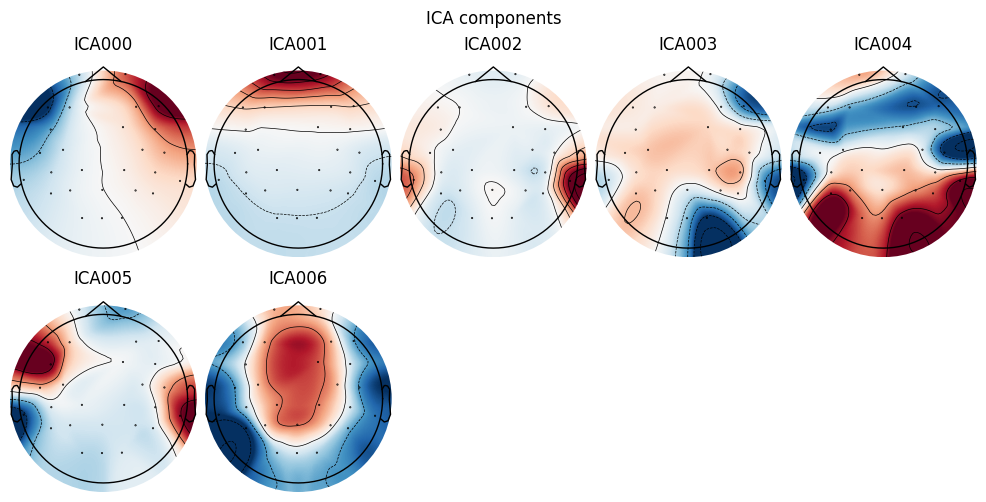

In [49]:
# plotting the model
ica.plot_components();

Creating RawArray with float64 data, n_channels=7, n_times=523240
    Range : 0 ... 523239 =      0.000 ...   523.239 secs
Ready.


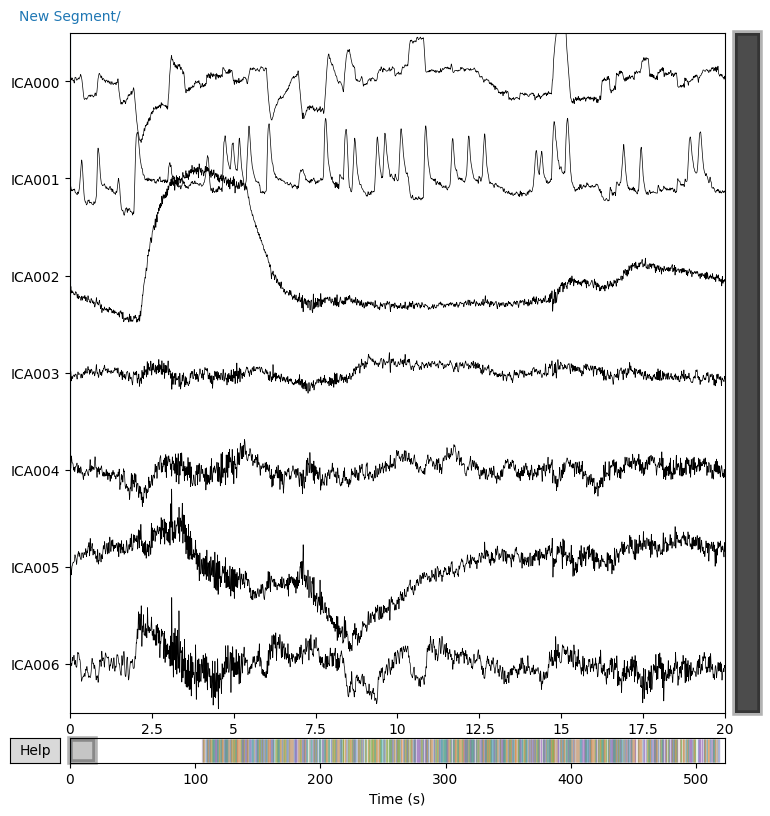

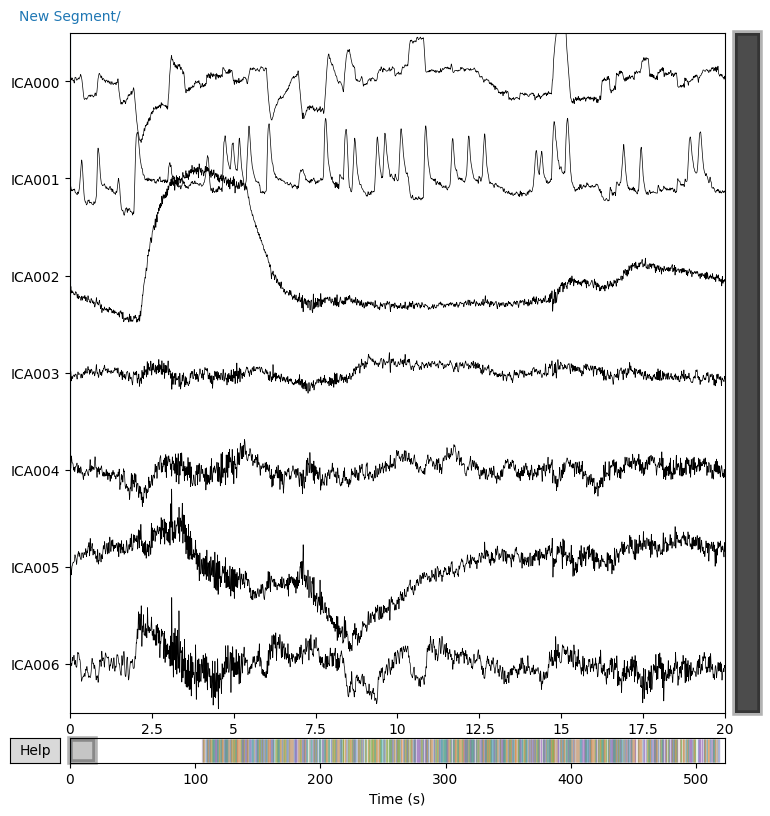

In [50]:
ica.plot_sources(raw1)

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated


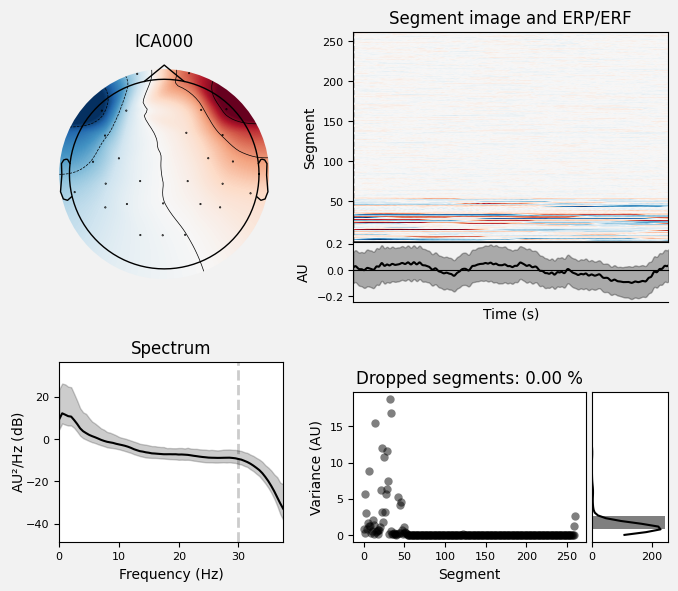

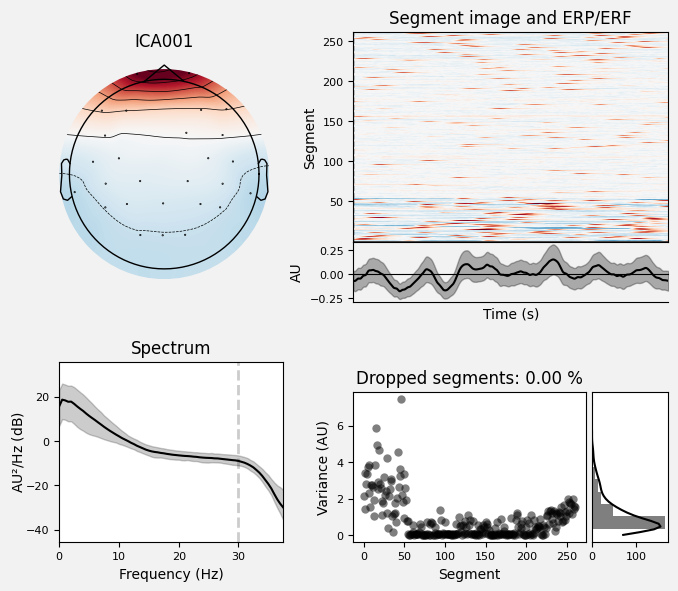

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [51]:
ica.plot_properties(raw1, picks=[0, 1])

In [52]:
# excluding the eyes
ica.exclude = [0,1]
ica.apply(raw1)

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 2 ICA components
    Projecting back using 27 PCA components


<RawBrainVision | Group12_own.eeg, 30 x 523240 (523.2 s), ~119.8 MB, data loaded>

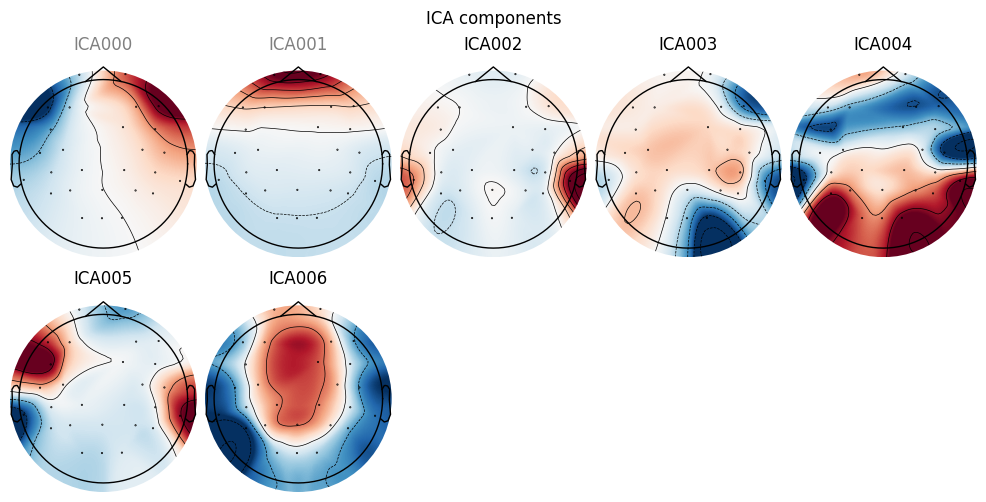

Creating RawArray with float64 data, n_channels=7, n_times=523240
    Range : 0 ... 523239 =      0.000 ...   523.239 secs
Ready.


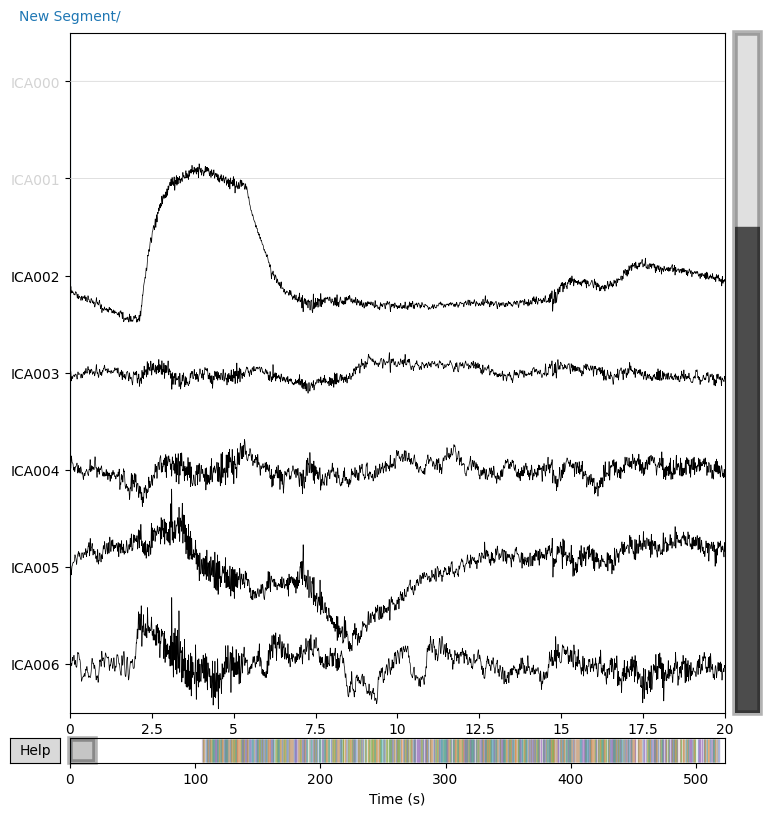

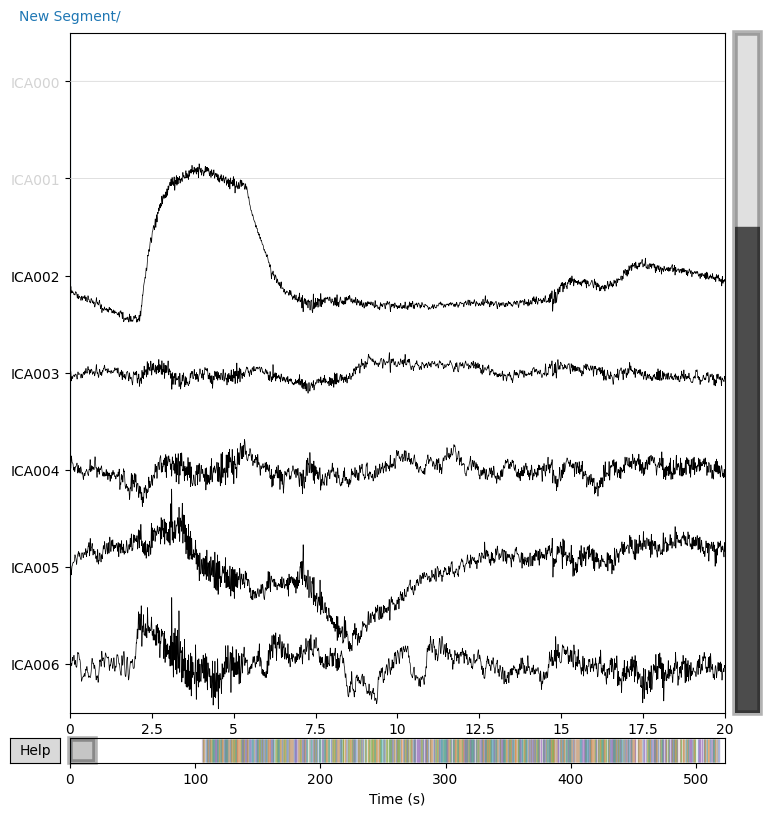

In [53]:
# Plot again after applying ICA
ica.plot_components()
ica.plot_sources(raw1)

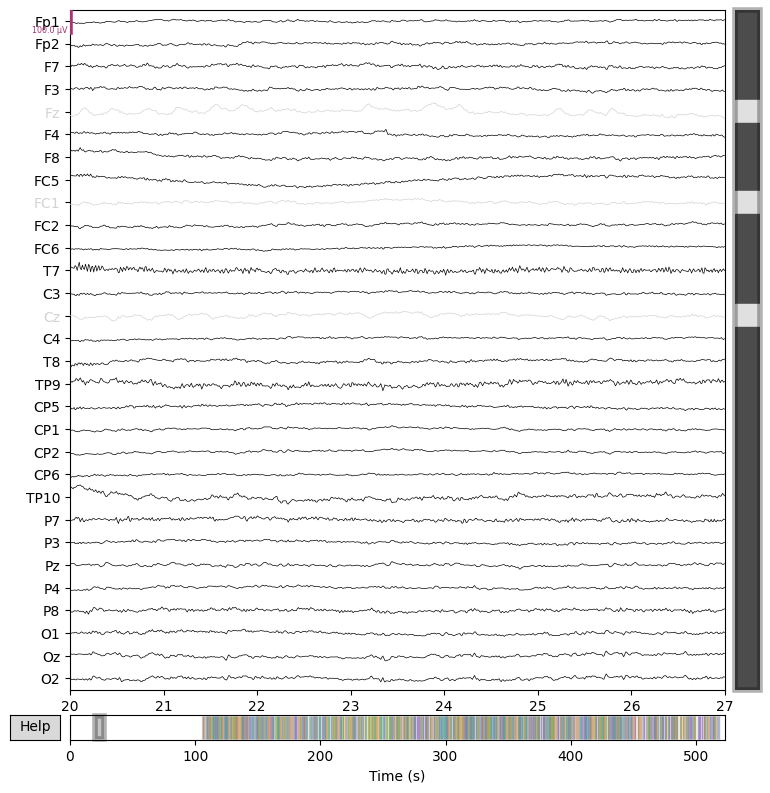

In [54]:
raw1.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20);

# 8. save the data

In [77]:
# save the data
import os

output_path = os.path.join(os.getcwd(), "preprocessed_data")

# make sure output path exists 
if not os.path.exists(output_path):
    os.mkdir(output_path)

# save the data
raw1.save(os.path.join(output_path, 'preprocessed_data_andreas.fif'), overwrite=True)

Overwriting existing file.
Writing /work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif


/tmp/ipykernel_7998/3593219163.py:11: RuntimeWarning: This filename (/work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw1.save(os.path.join(output_path, 'preprocessed_data_andreas.fif'), overwrite=True)


Closing /work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif
[done]


# Now lets do it for Andreas

# 1. Load the data - Andreas

In [56]:
# Load the data from second participant
path = "/work/raw/own_experiments/group12_own_AH-raw.fif"
raw2 = mne.io.read_raw_fif("/work/raw/own_experiments/group12_own_AH-raw.fif")

raw2.load_data()

channel_types = {
    '41': 'misc',     # Misc, the other two from above do not exist
    'PO9': 'eog',
    'PO10': 'eog',
}

# Find out channels 
print(raw2.info['ch_names'])
print(raw2.info['ch_names']) # seems like P09 and PO10 are replacementts for HEOG and VEOG


raw2.set_channel_types(channel_types)
print(raw2.get_channel_types())

Opening raw data file /work/raw/own_experiments/group12_own_AH-raw.fif...
    Range : 9000000 ... 9600000 =   9000.000 ...  9600.000 secs
Ready.
Reading 0 ... 600000  =      0.000 ...   600.000 secs...
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', '41']
['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', '41']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eog', 'eeg', 'eeg', 'eeg', 'eog', 'misc']


# 2. Specify the channel locations - Andreas

In [57]:
# Specify the channel locations
montage = mne.channels.make_standard_montage('standard_1020') 
raw2.set_montage(montage, verbose=False)

/tmp/ipykernel_7998/265437523.py:3: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['PO9', 'PO10']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw2.set_montage(montage, verbose=False)


<Raw | group12_own_AH-raw.fif, 33 x 600001 (600.0 s), ~151.1 MB, data loaded>

# 3. Common average reference - Andreas

In [58]:
# common average reference
raw2.set_eeg_reference('average', projection=True)

# applying the reference
raw2.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<Raw | group12_own_AH-raw.fif, 33 x 600001 (600.0 s), ~151.1 MB, data loaded>

# 4. plot the data - Andreas

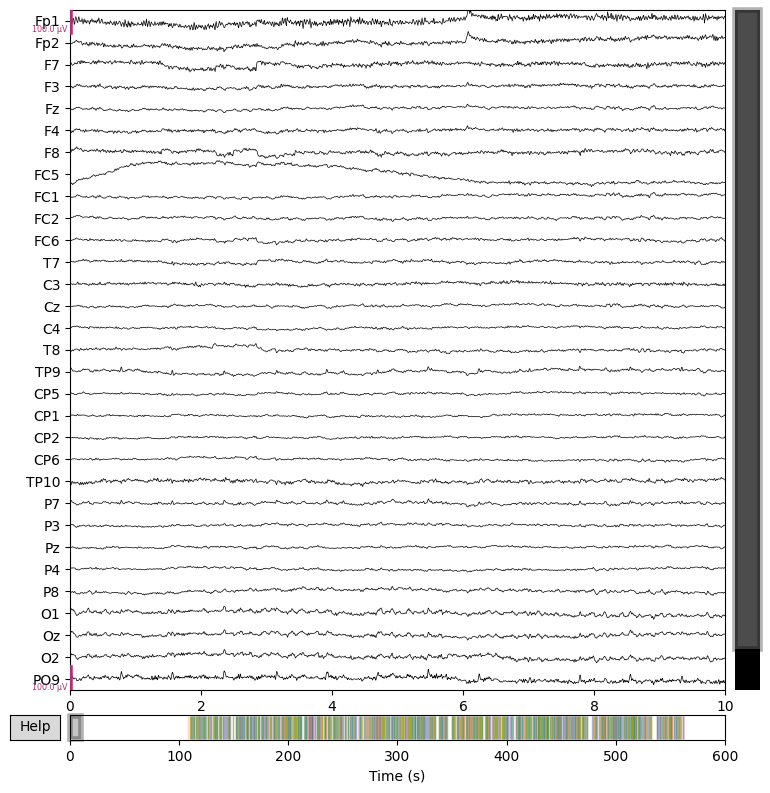

In [59]:
# Plot the data
raw2.plot(n_channels=31, scalings=50e-6);

# 5. Filter the data - Andreas

In [60]:
# Filter the data
raw2.filter(l_freq = 0.1, h_freq = 30) # 0.1 -30 is the convention, thats why use have specified these filters

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


<Raw | group12_own_AH-raw.fif, 33 x 600001 (600.0 s), ~151.1 MB, data loaded>

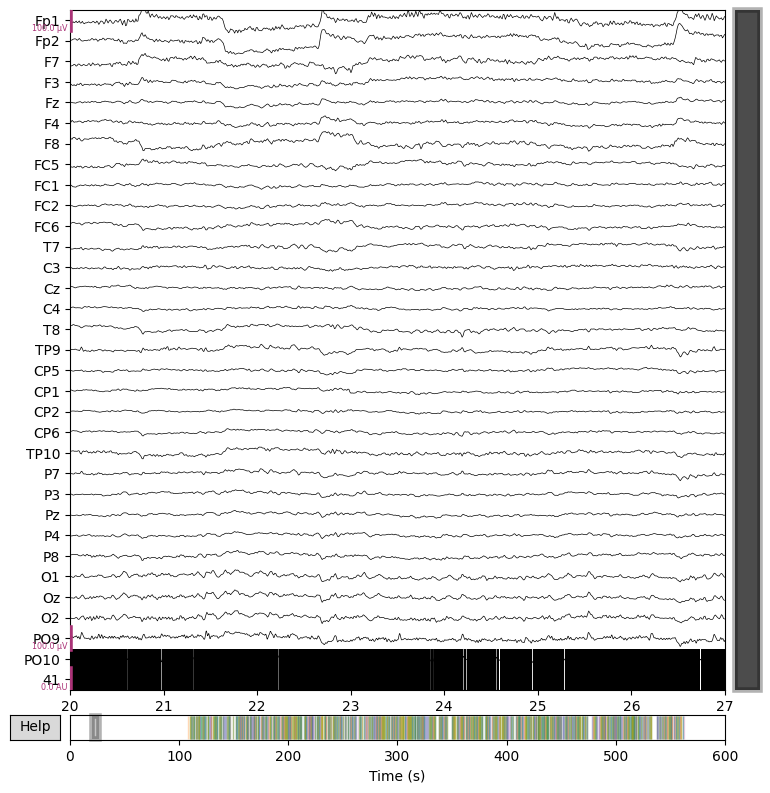

In [61]:
# Plot again to check
raw2.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20);

# 6. NOTE: i have not removed any channels, since it looks like Andreas don't have any bad ones

# 7. ICA 

In [62]:
raw2.pick_types(meg=False, eeg=True, stim=True, exclude=[])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | group12_own_AH-raw.fif, 30 x 600001 (600.0 s), ~137.4 MB, data loaded>

In [63]:
# fitting the model
ica = mne.preprocessing.ICA(n_components=0.95, max_iter=800, random_state=7)

ica.fit(raw2)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 14.3s.


<ICA | raw data decomposition, method: fastica (fit in 37 iterations on 600001 samples), 15 ICA components (30 PCA components available), channel types: eeg, no sources marked for exclusion>

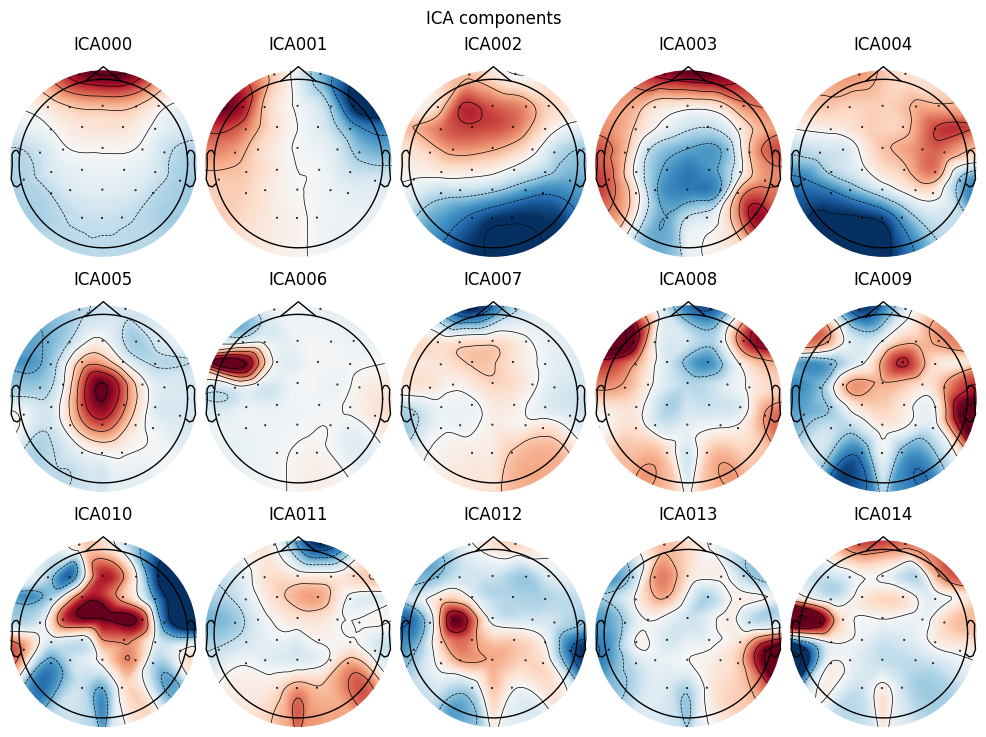

In [64]:
# plotting the model
ica.plot_components();

    Applying projection operator with 1 vector (pre-whitener application)


Creating RawArray with float64 data, n_channels=15, n_times=600001
    Range : 9000000 ... 9600000 =   9000.000 ...  9600.000 secs
Ready.


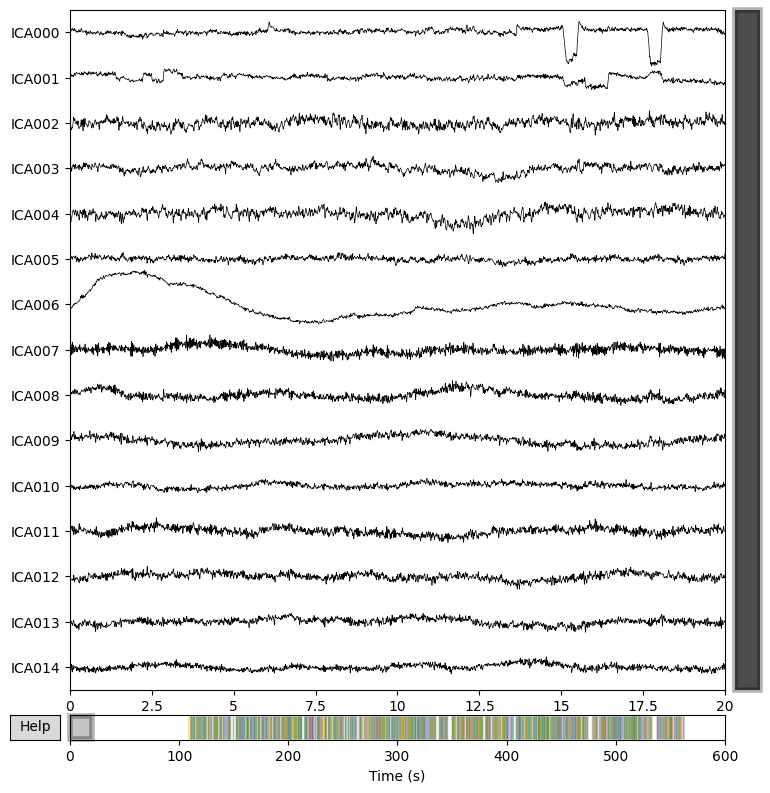

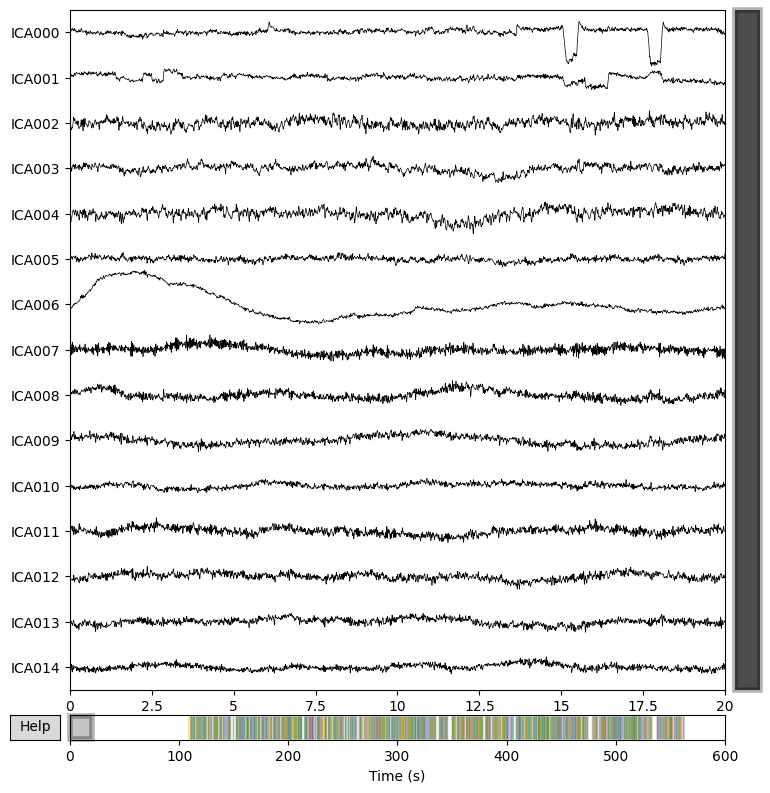

In [65]:
ica.plot_sources(raw2)

look at the properties

    Applying projection operator with 1 vector (pre-whitener application)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated


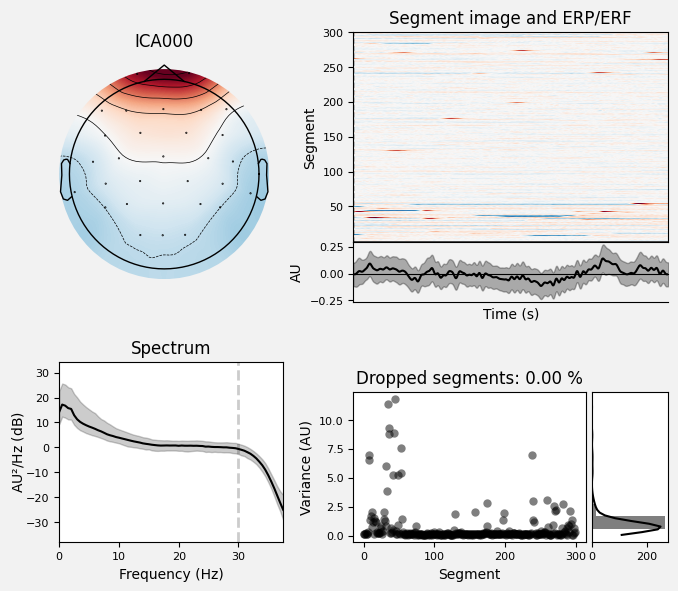

[<Figure size 700x600 with 6 Axes>]

In [66]:
ica.plot_properties(raw2, picks=[0])

In [67]:
# excluding the eyes
ica.exclude = [0]
ica.apply(raw2)

Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<Raw | group12_own_AH-raw.fif, 30 x 600001 (600.0 s), ~137.4 MB, data loaded>

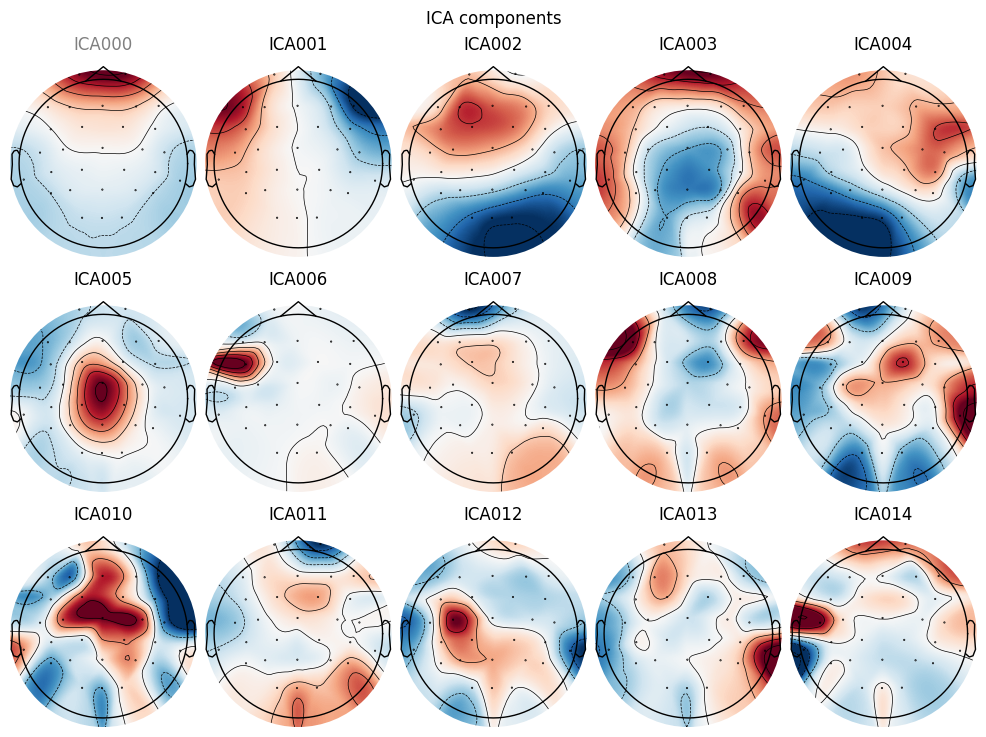

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=15, n_times=600001
    Range : 9000000 ... 9600000 =   9000.000 ...  9600.000 secs
Ready.


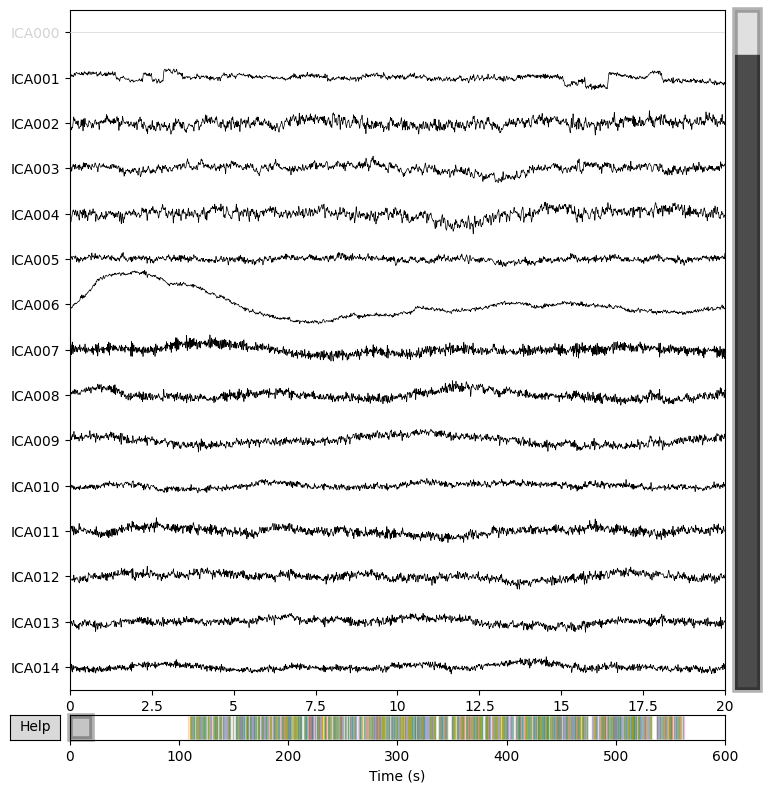

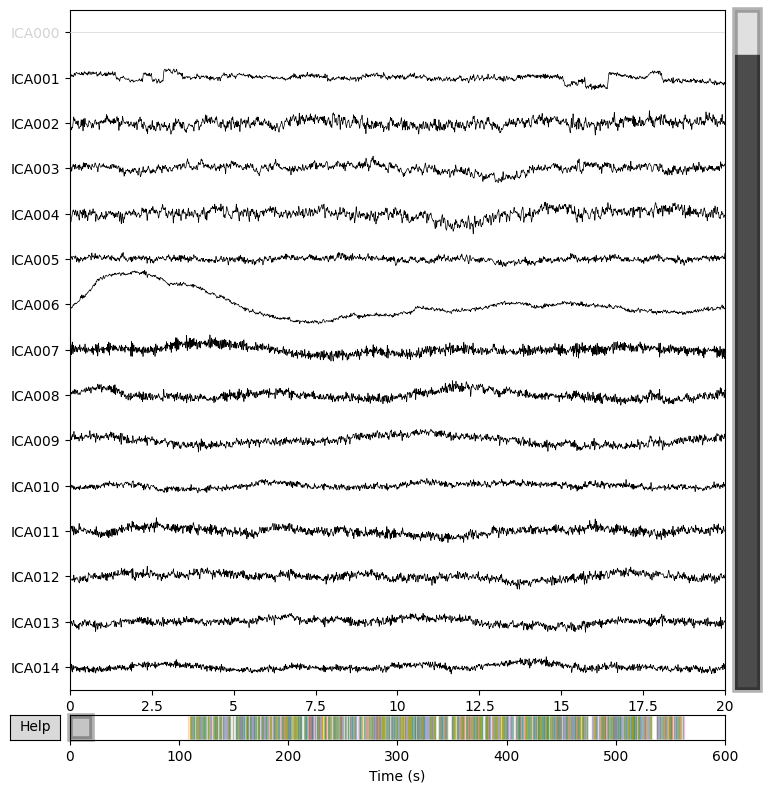

In [68]:
# Plot again after applying ICA
ica.plot_components()
ica.plot_sources(raw2)

Plot orginal data to see whether ICA has worked

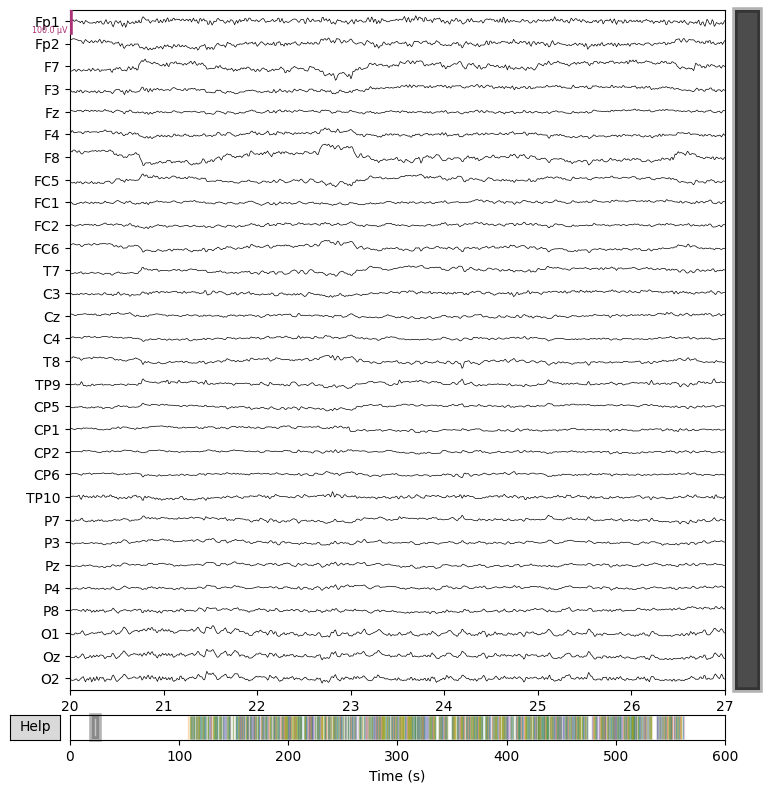

In [33]:
raw2.plot(n_channels=33, scalings=50e-6, duration = 7, start = 20);

In [76]:
# save the data
import os

output_path = os.path.join(os.getcwd(), "preprocessed_data")

# make sure output path exists 
if not os.path.exists(output_path):
    os.mkdir(output_path)

# save the data
raw2.save(os.path.join(output_path, 'preprocessed_data_andreas.fif'), overwrite=True)

Overwriting existing file.
Writing /work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif


/tmp/ipykernel_7998/275061356.py:11: RuntimeWarning: This filename (/work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw2.save(os.path.join(output_path, 'preprocessed_data_andreas.fif'), overwrite=True)


Closing /work/NadiaHajighassem#9723/CogNeuro24/EEG/friday/preprocessing/preprocessed_data/preprocessed_data_andreas.fif
[done]
